# fMRI-05 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

This notebook demonstrates a number of important postprocessing steps in fMRI analysis.

## Part 1: Smoothing

Often fMRI data are spatially smoothed prior to analysis. The extent of spatial smoothing will be dependent on your analysis of interest (e.g. studying large or small ROIs). Smoothing can be accomplished with a number of functions. Volumetric (Gaussian) smoothing can be performed with `scipy` and `nilearn` ([nilearn.image.smooth_img](https://nilearn.github.io/modules/generated/nilearn.image.smooth_img.html#nilearn.image.smooth_img) is probably easiest).

Smoothing Freesurfer surfaces is, unfortunately, best done with Freesurfer itself and can be performed on request using [mri_fwhm](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_fwhm) and [mri_surf2surf](http://freesurfer.net/fswiki/mri_surf2surf).

## Part 2: Filtering and Percent Signal Change

To remove low frequency drifts in the fMRI signal, we often highpass filter the data before analysis. This can be performed in a number of ways, but thankfully `nilearn` makes this very easy for us. We will use the `clean` function to highpass filter the data. The appropriate frequency cutoff may depend on your particular experiment, but standard default values are 1/100 (0.01) Hz, 1/128 Hz (0.0078), and 1/200 (0.005) Hz. 

By removing the low frequency trends in the data, applying a highpass filter will demean our data. This is not ideal if we are interested in converting our data to percent signal change ([Chen et al. 2017](https://www.sciencedirect.com/science/article/pii/S1053811916305432)). Thus, we will store the mean intensities of each voxel prior to filtering.

In [ ]:
import nibabel as nib
from nilearn.signal import clean

## Define metadata.
tr = 1
high_pass = 0.01

## Load data.
data = nib.load('sample.nii.gz').get_data()

## Compute mean signal.
mu = data.mean(axis=0)

## Apply highpass data.
data = clean(data, detrend=True, standardize=False, high_pass=high_pass, t_r=tr)

## Convert to percent signal change.
data = data / mu * 100

## Part 3: Nuisance Regressors 

Nuisance regressors describe additional timeseries we will include in our design matrix that will control for sources of noise in our data. Noise sources might include scanner artifact (e.g. drifts), motion artifact, and respiratory artifact. 

### Motion Regressors

The biggest source of noise is motion. We can effectively mitigate first-order motion effects (i.e. artifact immediately following a movement) using motion regressors. Motion regressors are estimates of the brain's movement in six directions (left/right, forward/backward, up/down, pitch, yaw, roll) over the course of the scan.

Typically we do not include the raw motion traces directly as nuisnace regressors. This is not done for a number of reasons, but the two most important are collinearity and high frequency noise. 

Collinearity arises whenever two (or more) timeseries are very similar creating a rank deficient design matrix. The result of this is numerical instability in estimating the regression weights. To combat this, we orthogonalize the motion regressors; in other words, we make it such that each motion regressor is fully independent of one another (completely uncorrelated). We do this through principal components analysis. We can then use estimates of the cumulative variance explained by each regressor (which naturally falls out from the eigenvalues of the PCA) to decide how many postprocessing motion regressors to include.

A second issue that has been pointed out is that motion regressors can inject high frequency noise into the regression if the estimates were generated from unfiltered data. The net result of this is effectively undoing our work in filtering the data. Thus, we often lowpass filter the motion regressors to remove high frequency components.



In [45]:
from pandas import read_table
from nilearn.signal import clean
from scipy.signal import detrend
from sklearn.decomposition import PCA

## Define metadata
pca_threshold = 0.8

## Load fmriprep confound regressors.
df = read_table('confound_regressors.tsv', sep='\t')

## Extract motion regressors.
cols = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
raw = df[cols].values

## Option 1: Linear detrending of regressors.
zscore = lambda arr: (arr - np.mean(arr)) / np.std(arr)
reg1 = detrend(raw, axis=0, type='linear')
reg1 = np.apply_along_axis(zscore, 0, reg1)

## Option 2: Filter regressors.
reg2 = clean(raw, low_pass=0.1, t_r=1)

## Perform PCA.
pca = PCA(n_components=6)
reg2 = pca.fit_transform(reg2)

## Take only the number of components explaining 90% of the variance.
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= pca_threshold) + 1
regressors = reg2[:,:n_components]

### Motion Scrubbers
With large movements, we might decide that a particular volume is suspect. In other words, if a participant moves their head too much, our motion regressors may not be able to compensate for signal deviations. In such instances, it may be preferable to use "motion scrubbers". These are nuisance regressors that are columns of zeros *except* for the infected volume, where a 1 is inserted instead. These act to effectively remove entirely the influence of that volume from the regression.

The threshold for what constitutes a large movement is not set in stone. For children or psychiatric patients, we expect more motion than "healthy" controls. Thankfully some guidelines have been put forward ([Power et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/23994314), [Siegel et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/23861343)). A rough threshold is to reject any volume with a framewise displacement value above 0.5 mm. This may need to be adjusted depending on the level of motion of the participant (of course, if a participant is moving a lot it is better just to throw away their data!). If 10%-20% of a participant's data is going to be rejected with even a liberal threshold (e.g. FD = 1.0mm), it may be better to exclude that participant's data.

0 bad volumes detected.


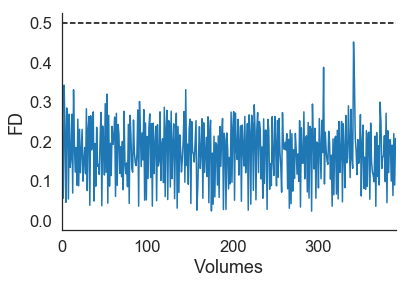

In [75]:
from pandas import read_table

## Define FD threshold.
fd_threshold = 0.5

## Load fmriprep confound regressors.
df = read_table('confound_regressors.tsv', sep='\t')

## Extract framewise displacement.
fd = df['framewise_displacement'].values
fd[np.isnan(fd)] = 0

## Identify infected volumes.
bad_vols = np.argwhere(fd > fd_threshold)
print('%s bad volumes detected.' %bad_vols.size)

## Construct scrubbers.
scrubbers = np.zeros((fd.size, bad_vols.size))
scrubbers[bad_vols, np.arange(fd.size)] = 1

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(fd)
ax.hlines(fd_threshold, 0, fd.size, linestyle='--')
ax.set(xlim=(0, fd.size), xlabel='Volumes', ylabel='FD')
sns.despine()

### CompCor Regressors

To remove physiological noise (e.g. respiration), some data-driven methods have been developed that come standard in fmriprep. One such example is component based noise correction method (CompCor) ([Behzadi et al. 2007](https://www.sciencedirect.com/science/article/pii/S1053811907003837?via%3Dihub])). CompCor attempts to estimate physiological noise from regions of the brain where we can be certain there is little-to-no neural activity (e.g. cerebrospinal fluid, white matter). The timecourses from these regions are extracted and passed through a semi-supervised dimensionality reduction processes. These are also available in fmriprep.

These may be helpful in removing respiration noise from your data, but one must be careful. If you expect that your task may accidentially cause respiration-task correlations (e.g. participant sighs relief at the end of hard trials), then this method may inadvertently remove task-related signal from your data.

Similar to the motion regressors, it might be wise to lowpass filter these data as well.

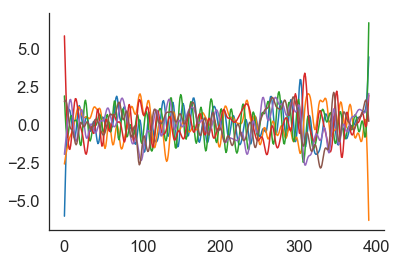

In [90]:
from pandas import read_table
from nilearn.signal import clean

## Load fmriprep confound regressors.
df = read_table('confound_regressors.tsv', sep='\t')

## Extract anatomical compcor signals.
compcor = df.filter(regex='a_comp_cor').values

## Filter regressors.
compcor = clean(compcor, low_pass=0.1, t_r=1)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(compcor)
sns.despine()